# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

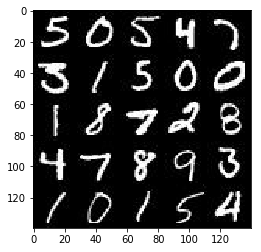

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

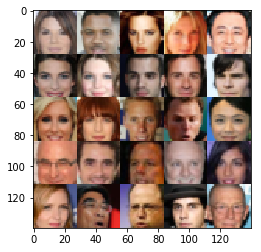

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim), name = 'input_z')
    lr = tf.placeholder(tf.float32)
    return input_real,input_z,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha= 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse= reuse):
        # inlut payer is 32,32,3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        #32/2=16,so 16*16*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #8*8*128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #4*4*256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides = 2, padding = 'same')
        bn4 = tf.layers.batch_normalization(x4, training = True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        #2*2*512
        
        flat = tf.reshape(relu4, (-1,2*2*512))
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
#     # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7,7,512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14,14,256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28,28,128
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides = 1, padding = 'same')
        x4 = tf.layers.batch_normalization(x4, training = is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #28,28,128
        
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5,  padding = 'same' )
        #28,28,out_channel_dim
        
        out = tf.tanh(logits)

    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha = alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True, alpha = alpha)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_real, labels = tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))

    discriminator_loss = d_loss_real + d_loss_fake
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In the train() function, make sure to rescale the batch_images correctly. In the project 5 notebook, it is mentioned that the values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.

However, if you’re using tanh in generator function to get logits then you have to rescale the images to be between -1 and 1 as mentioned in GAN_MNIST generator markdown cell.

Therefore you need to rescale the batch_images to (-1,1). You can include the below line of code in the train function;
batch_images = batch_images * 2

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    
    if data_image_mode == 'RGB':
        image_channel = 3
    else:
        image_channel = 1
        
    image_width = data_shape[1]
    image_height = data_shape[2]

    input_real,input_z, lr = model_inputs(image_width,
                                      image_height,
                                      image_channel, 
                                      z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, image_channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate,beta1)
    
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z
                                              })
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                               input_real: batch_images,
                                              })
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    gen_samples = sess.run(
                        generator(input_z, image_channel, False), 
                        feed_dict = {input_z: sample_z})
                    samples.append(gen_samples)
                    
                    _ = show_generator_output(sess, 4, input_z, image_channel, data_image_mode)
                    plt.show()
            
        
    return losses, samples
                  
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 2.4577
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.9332
Epoch 1/2... Discriminator Loss: 0.6757... Generator Loss: 1.8786
Epoch 1/2... Discriminator Loss: 0.4366... Generator Loss: 2.7013
Epoch 1/2... Discriminator Loss: 0.6897... Generator Loss: 6.4013
Epoch 1/2... Discriminator Loss: 2.5071... Generator Loss: 0.1562
Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 1.1709
Epoch 1/2... Discriminator Loss: 2.6460... Generator Loss: 0.1426
Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 0.3857
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 0.6929


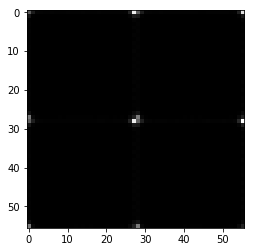

Epoch 1/2... Discriminator Loss: 2.6842... Generator Loss: 3.5644
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 0.8747
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 1.5056
Epoch 1/2... Discriminator Loss: 1.5778... Generator Loss: 0.3956
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.9221
Epoch 1/2... Discriminator Loss: 0.5892... Generator Loss: 1.9364
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 1.9806
Epoch 1/2... Discriminator Loss: 2.2536... Generator Loss: 0.1841


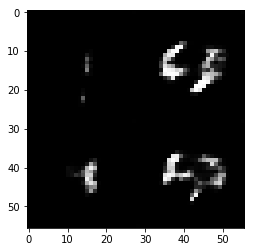

Epoch 1/2... Discriminator Loss: 1.7739... Generator Loss: 0.3068
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 1.1721
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 2.2980
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 1.9238
Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 1.6836
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 1.3066
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 1.1507
Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 1.6750


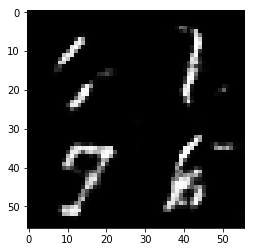

Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 1.3341
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.8824
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.8669
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 3.4837
Epoch 1/2... Discriminator Loss: 1.2887... Generator Loss: 1.7711
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 0.5348
Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 1.6030
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 1.0083
Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.8477


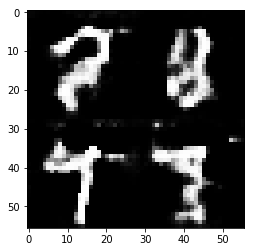

Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 0.6643
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 1.3182
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 1.0144... Generator Loss: 0.9450
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 0.7316
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.5204
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.7160


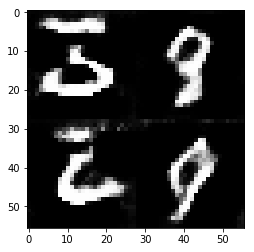

Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 1.4171
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 1.1681... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 1.2667
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 1.4987
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 1.4980


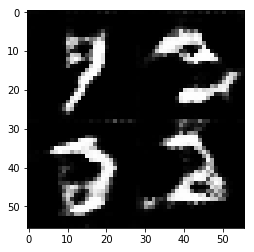

Epoch 1/2... Discriminator Loss: 1.8413... Generator Loss: 0.3267
Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.5195
Epoch 1/2... Discriminator Loss: 0.9652... Generator Loss: 0.9588
Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 1.8548
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 1.0182
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 1.0585
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 1.0736
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.6641


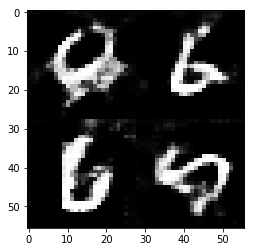

Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 1.6128
Epoch 1/2... Discriminator Loss: 0.7317... Generator Loss: 1.4202
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 0.6143... Generator Loss: 1.6592
Epoch 1/2... Discriminator Loss: 0.5594... Generator Loss: 2.2658
Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 1.7710... Generator Loss: 0.4318
Epoch 1/2... Discriminator Loss: 0.7553... Generator Loss: 1.6001
Epoch 1/2... Discriminator Loss: 0.6973... Generator Loss: 1.3475


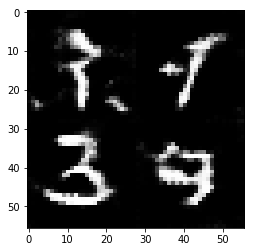

Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.8261
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 1.1133
Epoch 1/2... Discriminator Loss: 0.7447... Generator Loss: 1.2786
Epoch 1/2... Discriminator Loss: 1.8381... Generator Loss: 0.3290
Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 0.8323
Epoch 1/2... Discriminator Loss: 1.0323... Generator Loss: 1.5687
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.5844
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 1.3727
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.6083


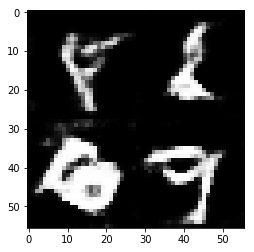

Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 1.3197
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 1.4305... Generator Loss: 0.5479
Epoch 1/2... Discriminator Loss: 1.5360... Generator Loss: 0.4372
Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 2.1006
Epoch 1/2... Discriminator Loss: 0.8692... Generator Loss: 1.0533
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 0.9375
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.6096
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 0.8977


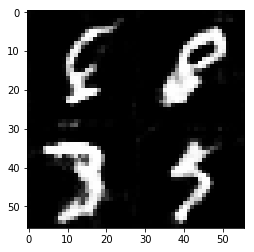

Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 0.7277
Epoch 1/2... Discriminator Loss: 1.7258... Generator Loss: 0.4074
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 0.9305
Epoch 1/2... Discriminator Loss: 1.7707... Generator Loss: 0.3407
Epoch 1/2... Discriminator Loss: 1.7434... Generator Loss: 1.0237
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 0.9211
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 1.8287
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 3.6925


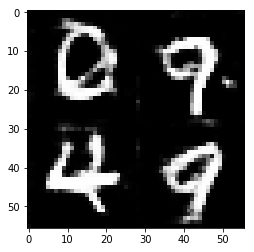

Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 0.7432
Epoch 1/2... Discriminator Loss: 1.5339... Generator Loss: 0.4734
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.6139
Epoch 1/2... Discriminator Loss: 1.6982... Generator Loss: 0.4878
Epoch 1/2... Discriminator Loss: 1.1070... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 1.7504
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.6331
Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 1.2341
Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 0.7259


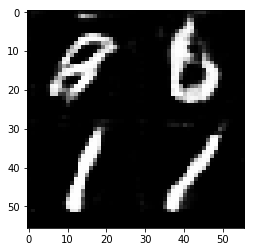

Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 1.0732
Epoch 1/2... Discriminator Loss: 0.4215... Generator Loss: 3.7630
Epoch 1/2... Discriminator Loss: 0.7481... Generator Loss: 1.2326
Epoch 1/2... Discriminator Loss: 2.0541... Generator Loss: 0.2375
Epoch 1/2... Discriminator Loss: 1.7403... Generator Loss: 0.4222
Epoch 1/2... Discriminator Loss: 1.0999... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 1.6214
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 1.7484
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 0.6643... Generator Loss: 1.5678


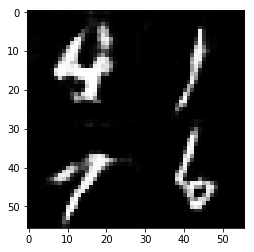

Epoch 1/2... Discriminator Loss: 0.7716... Generator Loss: 1.3258
Epoch 1/2... Discriminator Loss: 1.0863... Generator Loss: 1.2388
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.9695... Generator Loss: 0.2690
Epoch 1/2... Discriminator Loss: 1.1391... Generator Loss: 0.9332
Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 2.3480... Generator Loss: 0.1818
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.8542... Generator Loss: 0.3222


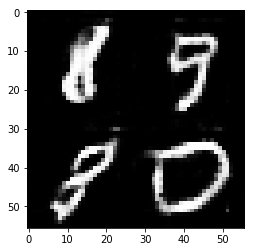

Epoch 1/2... Discriminator Loss: 1.5424... Generator Loss: 0.4388
Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 1.2134
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.1683
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.2663
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 0.7218... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.6271
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.4744
Epoch 1/2... Discriminator Loss: 2.2633... Generator Loss: 0.3426


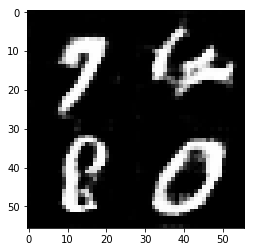

Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.1862... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 0.6566... Generator Loss: 1.5314
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.9778... Generator Loss: 0.2943
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 1.2102
Epoch 1/2... Discriminator Loss: 1.8958... Generator Loss: 0.3298
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 1.4420
Epoch 1/2... Discriminator Loss: 1.7968... Generator Loss: 0.3308


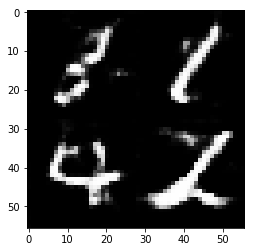

Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 1.0722
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 1.0311
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 1.1099
Epoch 1/2... Discriminator Loss: 1.6363... Generator Loss: 0.4414
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 1.0285
Epoch 1/2... Discriminator Loss: 1.8854... Generator Loss: 0.2989
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.5191
Epoch 1/2... Discriminator Loss: 0.6317... Generator Loss: 1.7119
Epoch 1/2... Discriminator Loss: 0.6481... Generator Loss: 1.6184


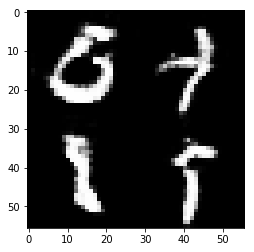

Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 1.2333
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.4783
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 2.2050
Epoch 1/2... Discriminator Loss: 2.0257... Generator Loss: 0.2753
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.4576
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.9665
Epoch 1/2... Discriminator Loss: 1.4716... Generator Loss: 3.4148
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 1.8372
Epoch 1/2... Discriminator Loss: 1.7566... Generator Loss: 0.3295
Epoch 1/2... Discriminator Loss: 0.8364... Generator Loss: 1.2979


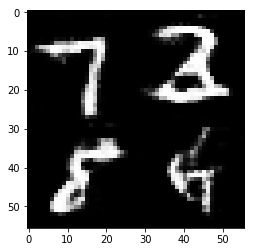

Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 0.5205
Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.7872
Epoch 1/2... Discriminator Loss: 0.9815... Generator Loss: 1.1042
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 2.8213
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.6206
Epoch 1/2... Discriminator Loss: 1.8270... Generator Loss: 0.2966
Epoch 2/2... Discriminator Loss: 1.1419... Generator Loss: 1.2996
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 1.1543
Epoch 2/2... Discriminator Loss: 1.4805... Generator Loss: 0.4481


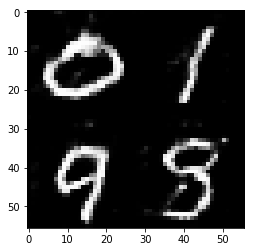

Epoch 2/2... Discriminator Loss: 2.2084... Generator Loss: 0.2559
Epoch 2/2... Discriminator Loss: 2.1227... Generator Loss: 0.2356
Epoch 2/2... Discriminator Loss: 0.8577... Generator Loss: 1.5215
Epoch 2/2... Discriminator Loss: 1.2882... Generator Loss: 0.5515
Epoch 2/2... Discriminator Loss: 0.6567... Generator Loss: 1.4254
Epoch 2/2... Discriminator Loss: 0.6873... Generator Loss: 1.3901
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.9902
Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 0.9590
Epoch 2/2... Discriminator Loss: 1.2908... Generator Loss: 0.5630


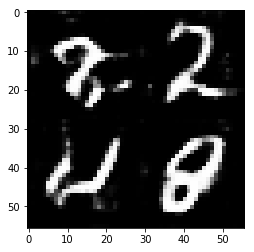

Epoch 2/2... Discriminator Loss: 1.4535... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 2.1405
Epoch 2/2... Discriminator Loss: 1.1222... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 0.6753
Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 1.2588
Epoch 2/2... Discriminator Loss: 0.9313... Generator Loss: 1.1523
Epoch 2/2... Discriminator Loss: 1.6230... Generator Loss: 0.4096
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 2.5859
Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.7736


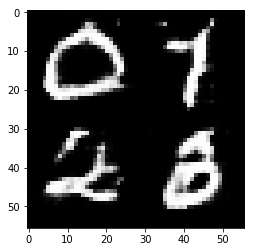

Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.5446
Epoch 2/2... Discriminator Loss: 0.5175... Generator Loss: 2.3030
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.1329
Epoch 2/2... Discriminator Loss: 2.4571... Generator Loss: 0.1738
Epoch 2/2... Discriminator Loss: 1.5923... Generator Loss: 2.1279
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.0914
Epoch 2/2... Discriminator Loss: 1.8825... Generator Loss: 0.3047
Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.6082
Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 1.7046


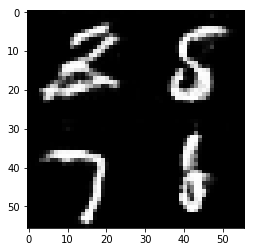

Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 0.9513
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 3.6243
Epoch 2/2... Discriminator Loss: 1.0725... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 2.0976... Generator Loss: 0.2394
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 1.0386
Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 1.7579
Epoch 2/2... Discriminator Loss: 1.1481... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.5413


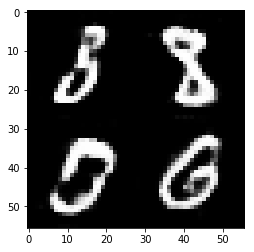

Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 1.8998
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 0.9353
Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 1.6592
Epoch 2/2... Discriminator Loss: 1.3448... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 0.6331... Generator Loss: 1.4969
Epoch 2/2... Discriminator Loss: 0.9573... Generator Loss: 0.8854
Epoch 2/2... Discriminator Loss: 1.7524... Generator Loss: 0.3577
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 1.5136
Epoch 2/2... Discriminator Loss: 1.0084... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.2770


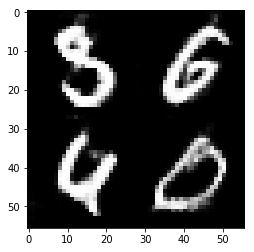

Epoch 2/2... Discriminator Loss: 0.8012... Generator Loss: 1.1085
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.4712
Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.5514
Epoch 2/2... Discriminator Loss: 0.8125... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 0.4955
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.5999
Epoch 2/2... Discriminator Loss: 1.7347... Generator Loss: 0.3830
Epoch 2/2... Discriminator Loss: 1.4561... Generator Loss: 0.6749


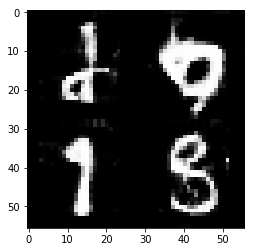

Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 1.4797... Generator Loss: 0.5106
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.5740
Epoch 2/2... Discriminator Loss: 1.5716... Generator Loss: 0.3990
Epoch 2/2... Discriminator Loss: 1.5690... Generator Loss: 0.5312
Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 0.7176
Epoch 2/2... Discriminator Loss: 1.9423... Generator Loss: 0.3139
Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.5185
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.8808
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 0.7955


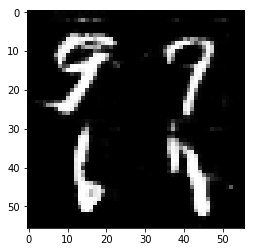

Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.6178
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.7332
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 1.9515
Epoch 2/2... Discriminator Loss: 0.6874... Generator Loss: 1.3489
Epoch 2/2... Discriminator Loss: 1.8716... Generator Loss: 0.4048
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 0.6839
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.5423
Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.2988


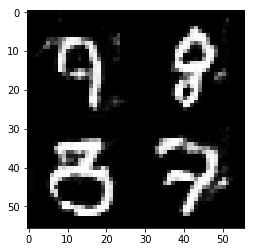

Epoch 2/2... Discriminator Loss: 1.6842... Generator Loss: 0.3635
Epoch 2/2... Discriminator Loss: 0.5824... Generator Loss: 1.8693
Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 1.5892
Epoch 2/2... Discriminator Loss: 0.9292... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.7503
Epoch 2/2... Discriminator Loss: 1.2088... Generator Loss: 2.2792
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 1.0126
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.1625
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.7333
Epoch 2/2... Discriminator Loss: 0.5958... Generator Loss: 1.6821


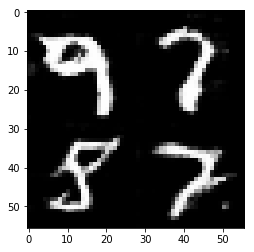

Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.1096
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 1.2759
Epoch 2/2... Discriminator Loss: 1.8166... Generator Loss: 0.3555
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.9596
Epoch 2/2... Discriminator Loss: 1.5267... Generator Loss: 0.4529
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 1.7698... Generator Loss: 0.3181
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 0.4862


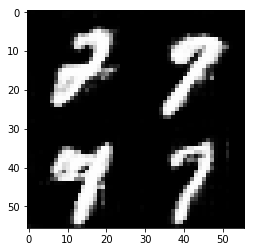

Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 1.4951... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 0.6074... Generator Loss: 1.9275
Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 1.5420
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.0975
Epoch 2/2... Discriminator Loss: 0.5830... Generator Loss: 1.8237
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 1.1671
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 2.7130


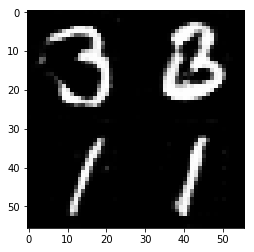

Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.9450
Epoch 2/2... Discriminator Loss: 1.5014... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 1.0794
Epoch 2/2... Discriminator Loss: 1.7410... Generator Loss: 0.4525
Epoch 2/2... Discriminator Loss: 0.6100... Generator Loss: 1.9596
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.4951
Epoch 2/2... Discriminator Loss: 1.4914... Generator Loss: 0.4583
Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 0.6069
Epoch 2/2... Discriminator Loss: 1.5513... Generator Loss: 0.4474
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.7634


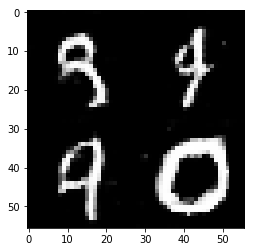

Epoch 2/2... Discriminator Loss: 1.8961... Generator Loss: 0.2816
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 0.7632
Epoch 2/2... Discriminator Loss: 1.3365... Generator Loss: 0.5052
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.1006
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 1.0776
Epoch 2/2... Discriminator Loss: 0.7430... Generator Loss: 1.2939
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 0.9260... Generator Loss: 1.3605


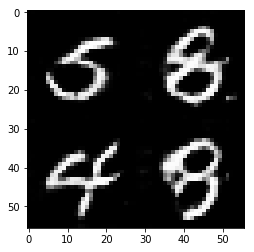

Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 2.2866... Generator Loss: 0.2221
Epoch 2/2... Discriminator Loss: 0.6875... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 1.6308
Epoch 2/2... Discriminator Loss: 1.4904... Generator Loss: 0.4399
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.5712
Epoch 2/2... Discriminator Loss: 0.4798... Generator Loss: 3.4726
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 1.4540... Generator Loss: 0.5569


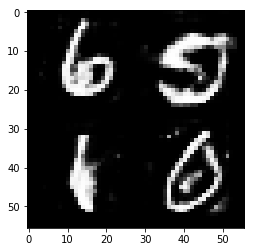

Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.5962
Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 1.9162
Epoch 2/2... Discriminator Loss: 0.7768... Generator Loss: 1.1696
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.6031
Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 1.4736
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 1.2091
Epoch 2/2... Discriminator Loss: 1.6617... Generator Loss: 0.3806
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 1.0088
Epoch 2/2... Discriminator Loss: 1.7639... Generator Loss: 0.3222
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.7223


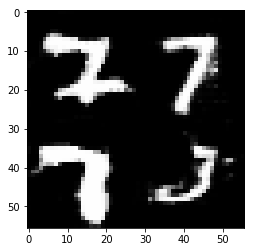

Epoch 2/2... Discriminator Loss: 2.1184... Generator Loss: 0.2347
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.7711
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 1.8156
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 1.1223
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.5138... Generator Loss: 0.4964
Epoch 2/2... Discriminator Loss: 0.6083... Generator Loss: 1.6168
Epoch 2/2... Discriminator Loss: 2.4401... Generator Loss: 0.2144


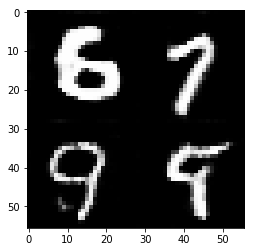

Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.2649
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 0.7644
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.5961
Epoch 2/2... Discriminator Loss: 1.0105... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 1.0525
Epoch 2/2... Discriminator Loss: 0.3824... Generator Loss: 3.5691
Epoch 2/2... Discriminator Loss: 2.5515... Generator Loss: 0.1548
Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 2.2852... Generator Loss: 0.2221
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.2882


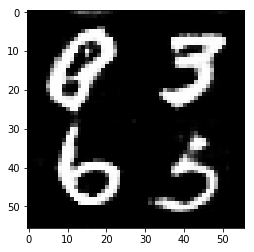

Epoch 2/2... Discriminator Loss: 2.2649... Generator Loss: 0.2482
Epoch 2/2... Discriminator Loss: 1.7921... Generator Loss: 0.3659
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.1878
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 0.5717
Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.2103
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.4657
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 1.0677


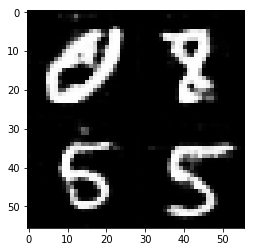

Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.8464
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.2054
Epoch 2/2... Discriminator Loss: 1.0411... Generator Loss: 0.8822
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 1.1491


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 13.1464
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.8375
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.8527
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 2.2962
Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 1.7838
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 7.0167


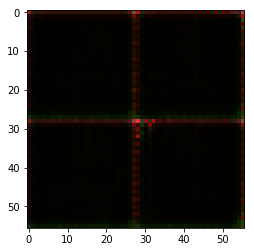

Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 3.2791
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 2.6900
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.8425... Generator Loss: 2.6844
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 2.0597... Generator Loss: 0.3092
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.5008


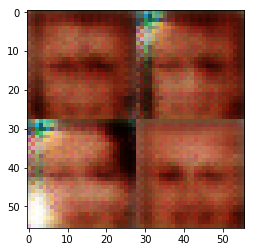

Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.7304... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 1.6215... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.9334


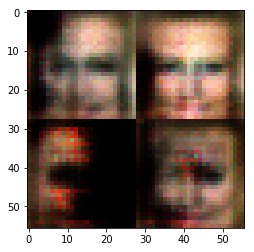

Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.8891... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.5406


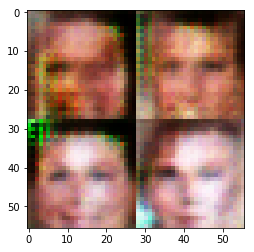

Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.7924... Generator Loss: 0.3157
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.4193
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7355


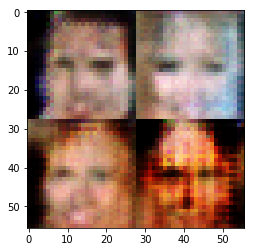

Epoch 1/1... Discriminator Loss: 1.8592... Generator Loss: 0.2690
Epoch 1/1... Discriminator Loss: 1.7645... Generator Loss: 2.7593
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.5615


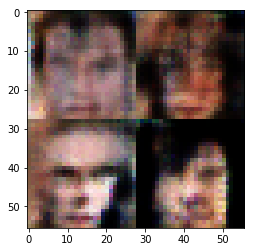

Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.5018
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 2.0812... Generator Loss: 0.2195
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.4769
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 1.6325


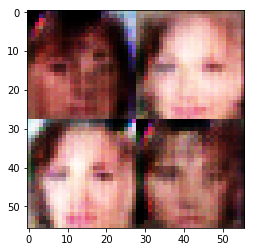

Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 2.3815... Generator Loss: 0.1544
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.7436... Generator Loss: 0.3266
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.5365


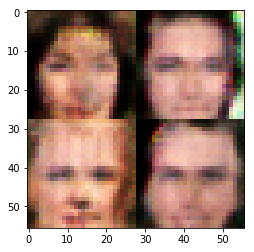

Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.8286... Generator Loss: 2.1698
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.5533


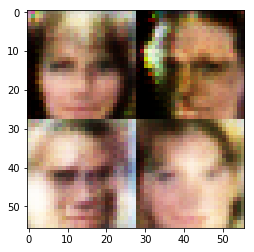

Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.9289


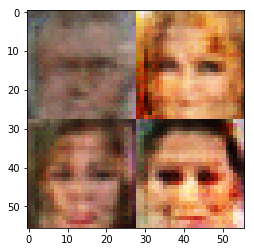

Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 1.7202
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.7734


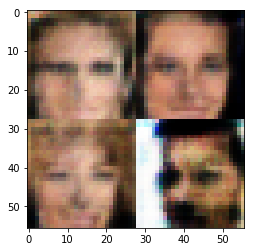

Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.6871... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.6772


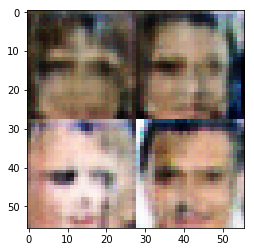

Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.5901... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.3980


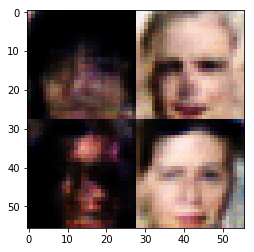

Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.8795... Generator Loss: 0.2718
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.4355


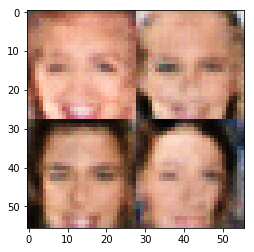

Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.6950... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.6734... Generator Loss: 0.3684
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.7370... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8707


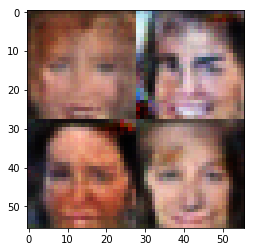

Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 2.1016... Generator Loss: 0.2061
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.1201


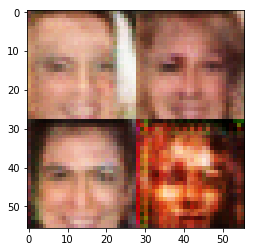

Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.7698... Generator Loss: 0.3669
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.9749


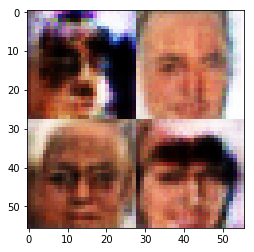

Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.7916... Generator Loss: 0.3157


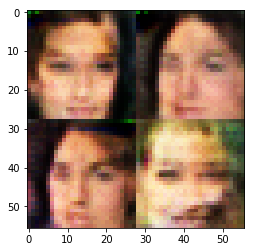

Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6395


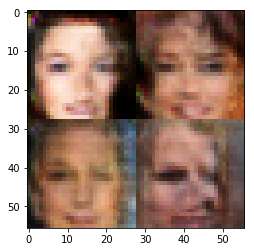

Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 1.0014


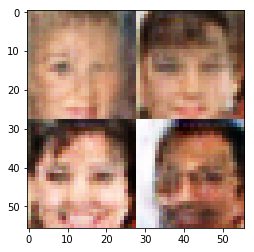

Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6455


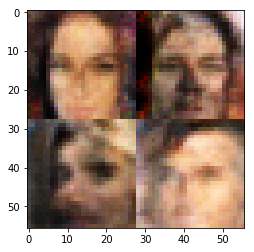

Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6261


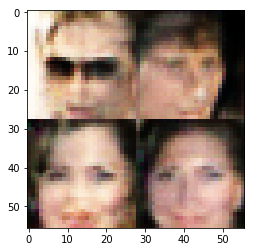

Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6885


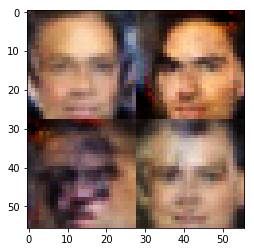

Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.8532


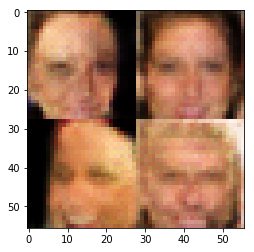

Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7753


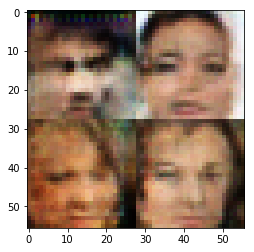

Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.5550


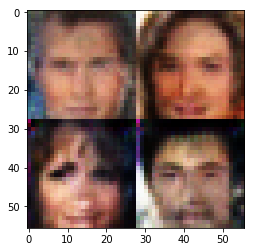

Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6341


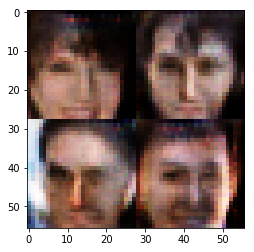

Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.9307


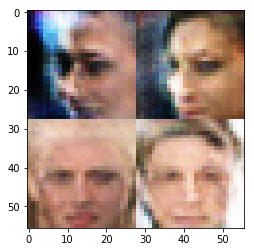

Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7983


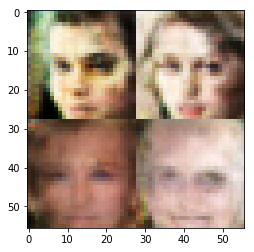

Epoch 1/1... Discriminator Loss: 1.6296... Generator Loss: 0.3625
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7916


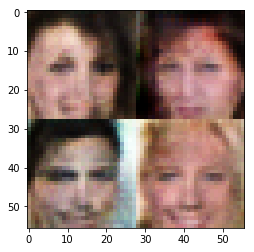

Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6421


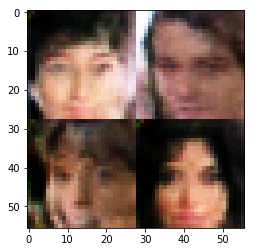

Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.5913


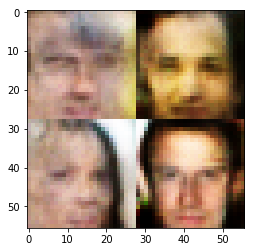

Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7158


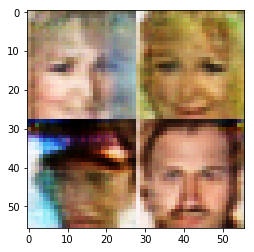

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.7004... Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6298


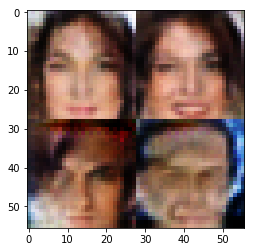

Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.5682


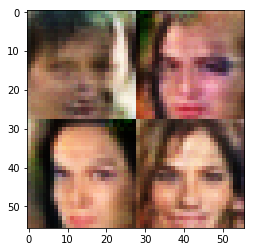

Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.7939


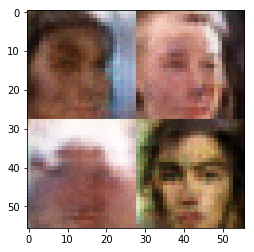

Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.3064
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.9180... Generator Loss: 0.2568
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.6214


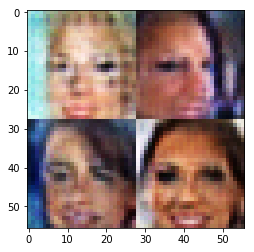

Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.9586


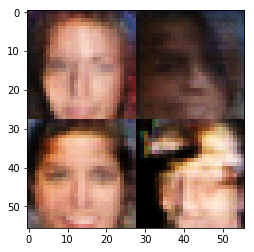

Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7204


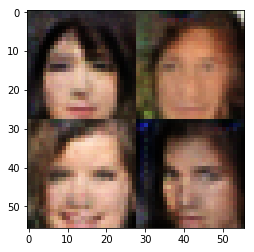

Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.5931


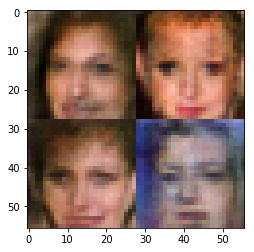

Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7506


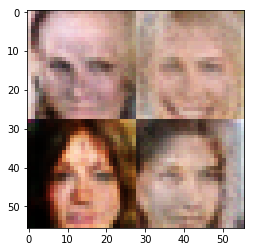

Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7968


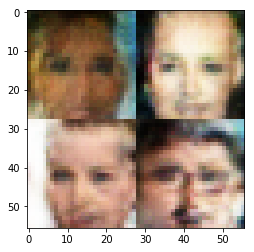

Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.5723


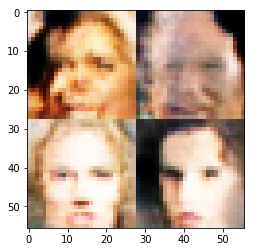

Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.9071


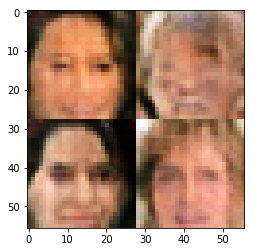

Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.8475


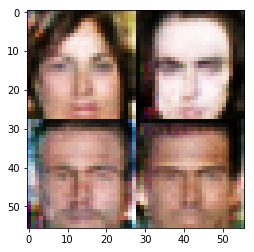

Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7251


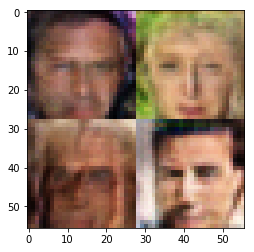

Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.6695... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7056


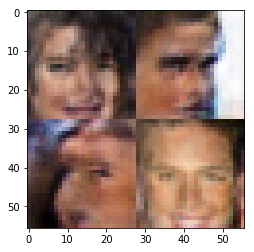

Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7365


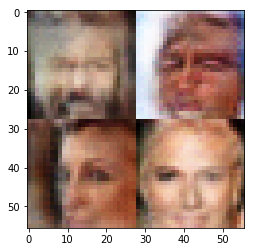

Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7175


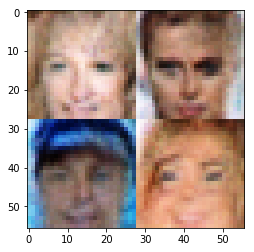

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6933


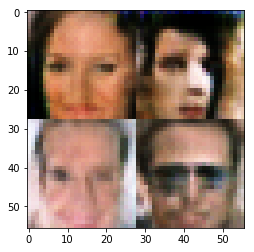

Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.8724


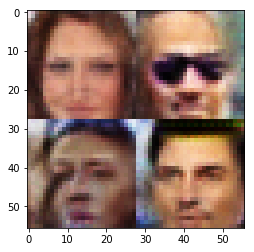

Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8206


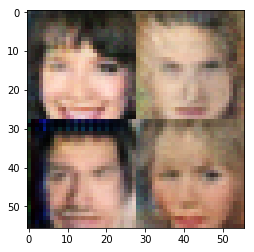

Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.7850


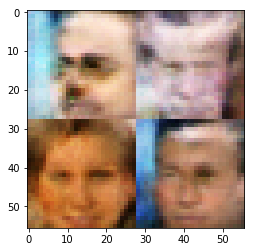

Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8834


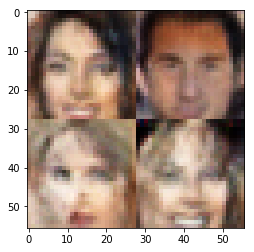

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7397


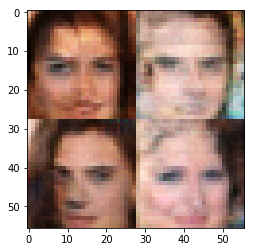

Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.9239


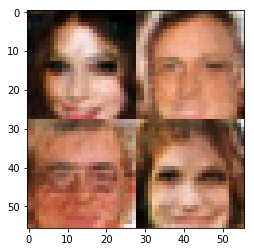

Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.7919


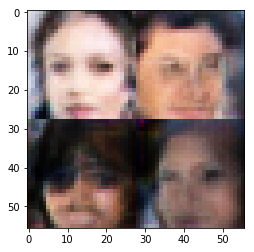

Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.7603


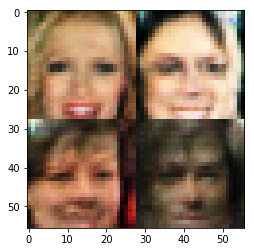

Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.8253... Generator Loss: 1.5787
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.7893


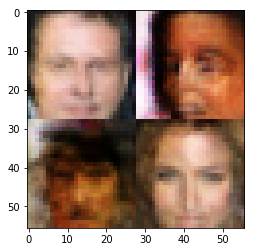

Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8745


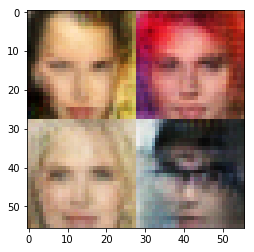

Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8874


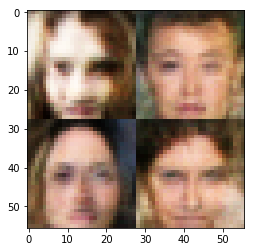

Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.8127


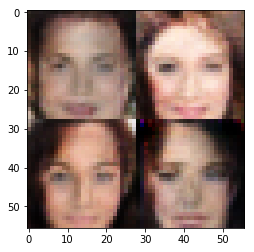

Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 1.0010


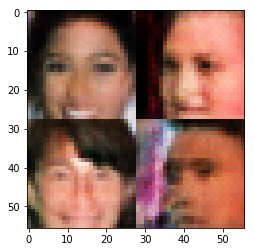

Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.7912


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.